In [1]:
import sys

sys.path.append("/home/devel/ws.leonid/lectures")
from l5_visualization.scripts.optimizators import DeepResp
import tensorflow as tf
import cv2
from pathlib import Path
import os
import PIL.Image
import numpy as np
import shutil

%load_ext autoreload
%autoreload 2
tf.get_logger().setLevel("INFO")

2022-10-30 15:10:52.289033: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-30 15:10:52.444498: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-30 15:10:53.043788: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-30 15:10:53.043845: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

## Оптимизация вероятности класса для визуализации сети
У нас есть модель, обученная решать задачу классификации: есть на человеке респиратор или нет.  
Модель обучалась на синтетических данных и обобщилась на настоящие тестовые данные.  
Хотим узнать: что смогла выучить модель, чтобы так хорошо обобщиться?


In [2]:
# load model
resp_class = tf.keras.models.load_model(f"../data/resp_class.hdf5", compile=False)
resp_class.summary()

2022-10-30 15:10:53.879909: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/devel/ws.leonid/lectures/.venv/lib/python3.8/site-packages/cv2/../../lib64:
2022-10-30 15:10:53.880535: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/devel/ws.leonid/lectures/.venv/lib/python3.8/site-packages/cv2/../../lib64:
2022-10-30 15:10:53.880551: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 16)   448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 64, 64, 16)   0           ['batch_normalization[0][0]']

In [3]:
# Create the feature extraction model
names = ["dense"]
layers = [resp_class.get_layer(name).output for name in names]

deepdream_model = tf.keras.Model(inputs=resp_class.input, outputs=layers)

In [4]:
# look at last dense layer's weights
for var in resp_class.trainable_variables:
    if var.name == "dense_1/kernel:0":
        print(f"kernel :{var.numpy()}")
    if var.name == "dense_1/bias:0":
        print(f"bias :{var.numpy()}")

kernel :[[ 6.1560322e-32]
 [-3.5944031e-33]
 [-3.0650073e-01]
 [-2.1344542e-33]
 [ 4.4798675e-13]
 [ 2.5179926e-01]
 [ 2.2920403e-01]
 [ 2.3665811e-01]]
bias :[-0.01513]


Видим, что активации 0, 4, 5, 6, 7 слоя "dense" умножаются на положительные веса, а активации 1, 2, 3 на отрицательные  
Так так классификатор решает, что на изображении нет респиратора, когда значение акцивации велико (во время обучения этот класс имел метку 1, а другой имел метку 0), то мы можем максимизировать значения этих активаций, чтобы получить изображение, классифицируемое как "лицо без респиратора" 

In [5]:
def no_resp_max_loss(img, model):
    C = 0.3
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    return (
        layer_activations[0][0] * 1
        + layer_activations[0][4] * 1
        + layer_activations[0][5] * 1
        + layer_activations[0][6] * 1
        + layer_activations[0][7] * 1
        - C * tf.image.total_variation(img)
    )


def generate_samples(loss, out_path, steps=200, lr=0.01, num_samples=5):
    shutil.rmtree(out_path, ignore_errors=True)
    out_path.mkdir(parents=True)
    dr = DeepResp(deepdream_model, loss, steps, lr)
    for i in range(num_samples):
        random_image = tf.random.uniform(
            [64, 64, 3],
            minval=0,
            maxval=None,
            dtype=tf.dtypes.float32,
            seed=None,
            name=None,
        )
        image = dr(random_image)
        image_to_save = cv2.cvtColor(image.numpy(), cv2.COLOR_RGB2BGR)
        image_to_save = cv2.resize(image_to_save, (256, 256))
        cv2.imwrite(str(out_path / f"{i}.jpg"), image_to_save)

In [6]:
out_root_dir = Path("../outputs/resp_vis_run_0")

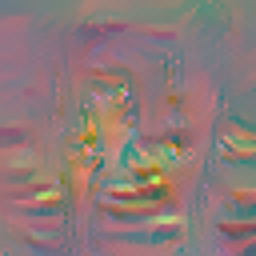

In [7]:
out_path = out_root_dir / Path("no_resp_max")
generate_samples(no_resp_max_loss, out_path, steps=400)

Будем максимизировать вероятность наличия респиратора

In [8]:
def resp_max_loss(img, model):
    C = 0.3
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    return (
        layer_activations[0][1] * 1
        + layer_activations[0][2] * 1
        + layer_activations[0][3] * 1
        - C * tf.image.total_variation(img)
    )

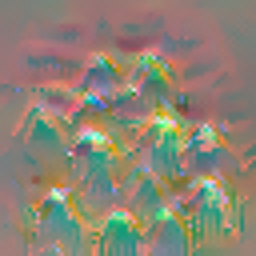

In [9]:
out_path = out_root_dir / Path("resp_max")
generate_samples(resp_max_loss, out_path, steps=400)

Начнём с зелёного изображения

In [10]:
def generate_samples_green_start(loss, out_path, steps=200, lr=0.01, num_samples=5):
    shutil.rmtree(out_path, ignore_errors=True)
    out_path.mkdir(parents=True)
    dr = DeepResp(deepdream_model, loss, steps, lr)
    for i in range(num_samples):
        random_image = tf.random.uniform(
            [64, 64, 3],
            minval=0,
            maxval=None,
            dtype=tf.dtypes.float32,
            seed=None,
            name=None,
        )
        color = np.zeros(
            [64, 64, 3],
            dtype=np.float32,
        )
        color[:, :, 0] = 0.3
        color[:, :, 1] = 0.7
        color[:, :, 2] = 0.3
        color = tf.convert_to_tensor(color) + random_image / 10
        image = dr(color)
        image_to_save = cv2.cvtColor(image.numpy(), cv2.COLOR_RGB2BGR)
        image_to_save = cv2.resize(image_to_save, (256, 256))
        cv2.imwrite(str(out_path / f"{i}.jpg"), image_to_save)

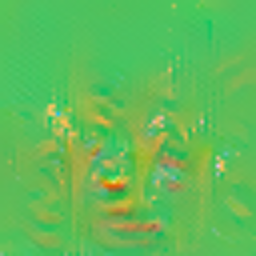

In [11]:
out_path = out_root_dir / Path("no_resp_max_green")
generate_samples_green_start(no_resp_max_loss, out_path, steps=300)

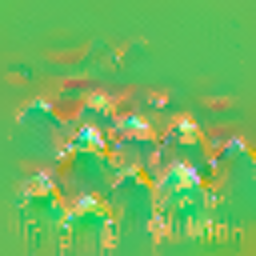

In [12]:
out_path = out_root_dir / Path("resp_max_green")
generate_samples_green_start(resp_max_loss, out_path, steps=300)